In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df = pd.read_csv("Fuel-type-Z.csv")

In [31]:
# Define feature groups
feature_poly = ['Fuel_City_log', 'Fuel_Hwy_log']      # apply degree 2
feature_linear = ['Engine_Size_log', 'Fuel_Comb_log', 'Cylinders_3','Cylinders_4'
                  ,'Cylinders_5','Cylinders_6','Cylinders_8','Cylinders_10','Cylinders_12'
                  ,'Cylinders_16'] # keep linear
target = 'CO2 Emissions(g/km)'

# Prepare X and y
X = df[feature_poly + feature_linear]
y = df[target]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ColumnTransformer to apply PolynomialFeatures only to selected columns
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), feature_poly),
        ('linear', 'passthrough', feature_linear)
    ]
)

# Build pipeline: preprocessing + scaler + Ridge regression
pipeline = Pipeline(steps=[
    ('features', preprocessor),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=2.0))  # L2 regularization strength (adjust as needed)
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


R² Score: 0.9969
RMSE: 3.18


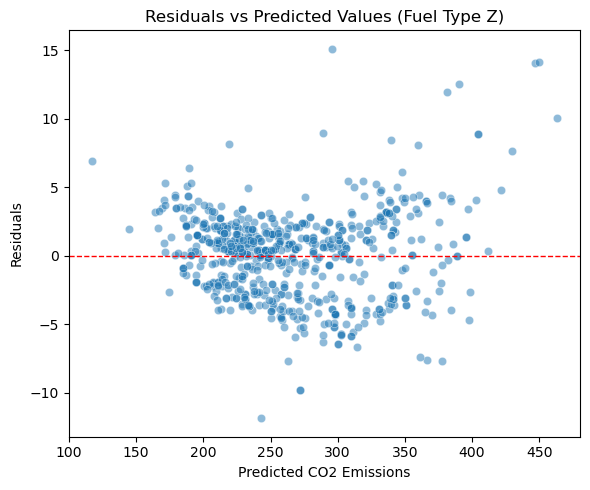

In [32]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs predicted values
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted CO2 Emissions")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (Fuel Type Z)")
plt.tight_layout()
plt.show()


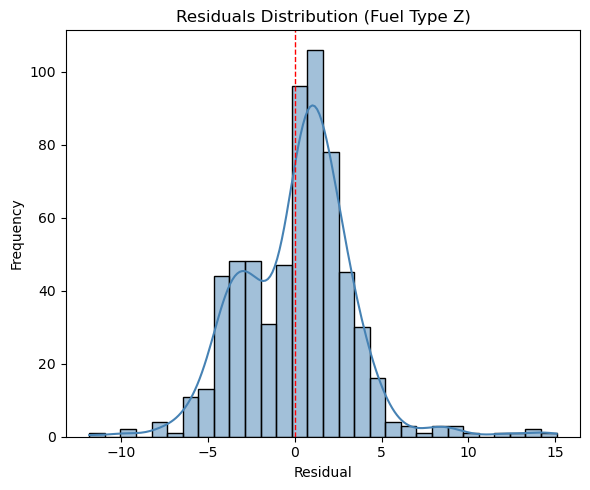

In [33]:
# Histogram of residuals
plt.figure(figsize=(6, 5))
sns.histplot(residuals, bins=30, kde=True, color='steelblue')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Fuel Type Z)")
plt.tight_layout()
plt.show()


In [34]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# 1. Define target and features
feature_poly = ['Fuel_City_log', 'Fuel_Hwy_log', 'Fuel_Comb_log']
feature_linear = ['Engine_Size_log', 'Cylinders_3','Cylinders_4',
                  'Cylinders_5','Cylinders_6','Cylinders_8','Cylinders_10',
                  'Cylinders_12','Cylinders_16']
target = 'CO2 Emissions(g/km)'

# 2. Remove outliers from target
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]

# 3. Log-transform the target
df_filtered['log_target'] = np.log(df_filtered[target])

# 4. Prepare inputs
X = df_filtered[feature_poly + feature_linear]
y = df_filtered['log_target']

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), feature_poly),
        ('linear', 'passthrough', feature_linear)
    ]
)

# 7. Ridge Regression pipeline
pipeline = Pipeline(steps=[
    ('features', preprocessor),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=2.0))  # L2 regularization
])

# 8. Train model
pipeline.fit(X_train, y_train)

# 9. Predict in log-space and revert to original scale
y_pred_log = pipeline.predict(X_test)
y_pred = np.exp(y_pred_log)
y_true = np.exp(y_test)

# 10. Evaluate
r2 = r2_score(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


R² Score: 0.9967
RMSE: 3.11


C:\Users\fahad\AppData\Local\Temp\ipykernel_8620\2145743533.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_target'] = np.log(df_filtered[target])


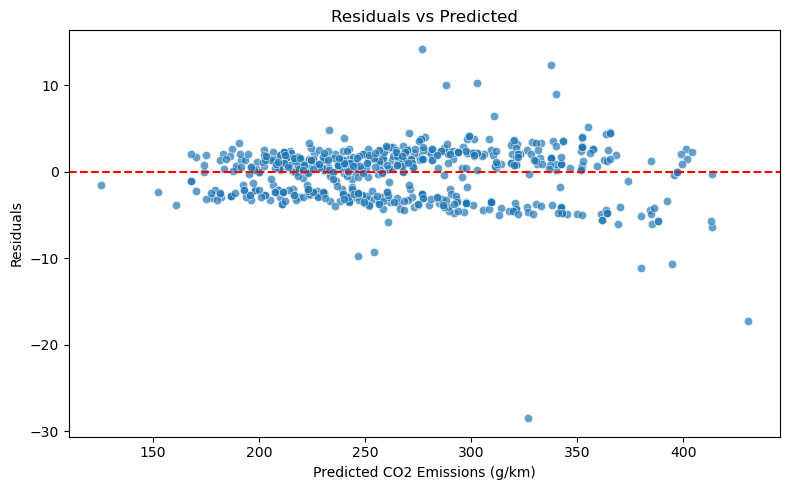

In [35]:
# Residuals
residuals = y_true - y_pred

# Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CO2 Emissions (g/km)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

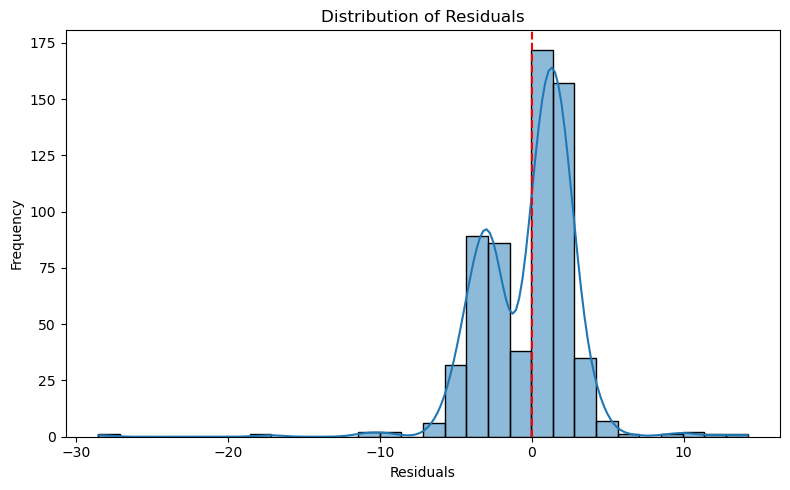

In [36]:
# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.tight_layout()
plt.show()


### **🔁 Transition to ElasticNet with Polynomial Features (Degree = 2)**
Our Ridge-regularized model showed signs of:

Residuals not being normally distributed

Heteroscedasticity in residuals (non-constant variance)

Potential bias and underfitting, especially in extreme predicted values

These suggest that linear + Ridge was too simplistic to capture complex relationships in the data. We now aim to:

### **✅ New Plan**
Model Type: ElasticNet (combination of Lasso and Ridge)
Why ElasticNet?

Performs both feature selection (via L1 penalty)

Controls multicollinearity and overfitting (via L2 penalty)

Especially helpful with polynomial features that can explode in number and magnitude

Feature Expansion:

Use Higher PolynomialFeatures to introduce interactions and nonlinearities

Standardize all features using StandardScaler (important for ElasticNet)

### **📌 Goals**
Improve model flexibility without overfitting

Let ElasticNet automatically reduce coefficients of irrelevant or weak features

Address both bias and variance issues observed in residual plots

